In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro, probplot
from scipy.special import boxcox1p

import statsmodels.api as sm
from statsmodels.formula.api import ols 

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings('ignore')

from time import time

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


## Removing outliers

In [3]:
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace = True)
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace = True)
train.reset_index(drop=True, inplace=True)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1457, 81)

In [5]:
sale_price_df = train[['SalePrice']].copy()

### rbinding train and test data

In [6]:
data = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)
data.shape

(2916, 80)

### checking for presence of null

In [7]:
data.isnull().sum()[data.isnull().sum()!=0]

MSZoning           4
LotFrontage      485
Alley           2718
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2907
Fence           2345
MiscFeature     2811
SaleType           1
dtype: int64

Filling NA values of numerical columns

In [8]:
for col in ['BsmtHalfBath','BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

for col in ['LotFrontage', 'MasVnrArea']:
    data[col] = data[col].fillna(data[col].median())
    
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [9]:
for col in ['MasVnrType', 'Electrical']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
for col in ['Alley', 'GarageType', 'GarageFinish', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1', 'PoolQC',
            'BsmtFinType2', 'FireplaceQu', 'GarageQual',  'GarageCond','Fence', 'MiscFeature']:
    data[col] = data[col].fillna('None')
    
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
data['GarageCond'] = data['GarageCond'].fillna('None')
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [10]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

### Creating new features

In [11]:
data['House_Qual'] = data['OverallQual'] + data['OverallCond']
data['Total_bathrooms'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
data['Total_basement_SF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['TotalBsmtSF']
data['Total_sqr_footage'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']

#### Some of the non-numeric predictors are stored as numbers; convert them into strings 

In [12]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

### Dropping ID column

In [13]:
data.drop(columns = 'Id', inplace = True)

### Dealing with all object/category type columns
Converting object columns to ordinal category type

In [14]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual','GarageCond']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['PoolQC'] = data['PoolQC'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType2', 'BsmtFinType1']:
    data[col] = data[col].astype(cat_type)

In [15]:
cat_type = CategoricalDtype(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True)
data['Fence'] = data['Fence'].astype(cat_type)

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['KitchenQual'] = data['KitchenQual'].astype(cat_type).cat.codes
data['HeatingQC'] = data['HeatingQC'].astype(cat_type)

cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type)

cat_type = CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)
data['Utilities'] = data['Utilities'].astype(cat_type)

cat_type = CategoricalDtype(['Sev', 'Mod', 'Gtl'], ordered=True)
data['LandSlope'] = data['LandSlope'].astype(cat_type)

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual', 'ExterCond']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],ordered=True)
data['Functional'] = data['Functional'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type)

cat_type = CategoricalDtype(['N', 'P', 'Y'],ordered=True)
data['PavedDrive'] = data['PavedDrive'].astype(cat_type)

### Create new features

In [16]:
data['Has_Garage'] = np.where(data['GarageArea']>0,1,0)
data['Has_2ndFlr'] = np.where(data['2ndFlrSF']>0,1,0)
data['Has_Pool'] = np.where(data['PoolArea']>0 , 1, 0)
data['Has_basement'] = np.where(data['Total_basement_SF'] > 0, 1, 0)
data['Has_fireplace'] = np.where(data['Fireplaces']>0,1,0)
data['Has_wooddeck'] = np.where(data['WoodDeckSF']>0,1,0)
data['Has_Open_Porch'] = np.where(data['OpenPorchSF']>0,1,0)
data['Has_EnclosedPorch'] = np.where(data['EnclosedPorch']>0,1,0)
data['Has_3SsnPorch'] = np.where(data['3SsnPorch']>0,1,0)
data['Has_ScreenPorch'] = np.where(data['ScreenPorch']>0,1,0)

In [17]:
data.shape

(2916, 93)

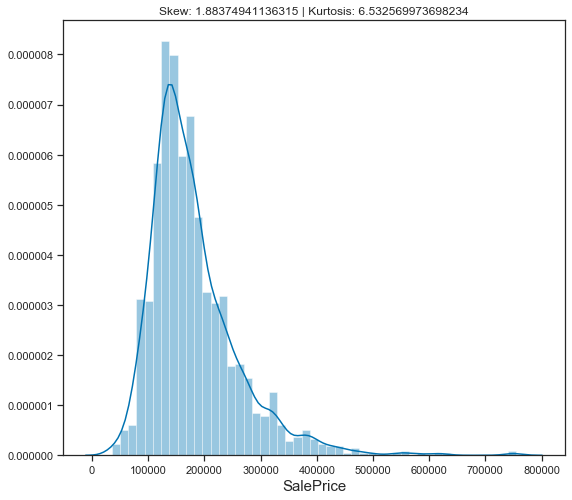

In [18]:
sns.distplot(sale_price_df['SalePrice']);
plt.title("Skew: {} | Kurtosis: {}".format(sale_price_df['SalePrice'].skew(), sale_price_df['SalePrice'].kurt()));

In [19]:
numeric_columns = data.select_dtypes('number').columns
numeric_columns = numeric_columns[~numeric_columns.str.contains('^Has')]
numeric_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'House_Qual', 'Total_bathrooms', 'Total_basement_SF',
       'Total_sqr_footage'],
      dtype='object')

In [20]:
len(numeric_columns)

38

In [21]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()
X_train = pd.concat([X_train,sale_price_df['SalePrice']], axis = 1)

In [22]:
X_train.dtypes

MSSubClass             object
MSZoning               object
LotFrontage           float64
LotArea                 int64
Street                 object
Alley                  object
LotShape             category
LandContour          category
Utilities            category
LotConfig              object
LandSlope            category
Neighborhood           object
Condition1             object
Condition2             object
BldgType               object
HouseStyle             object
OverallQual             int64
OverallCond             int64
YearBuilt               int64
YearRemodAdd            int64
RoofStyle              object
RoofMatl               object
Exterior1st            object
Exterior2nd            object
MasVnrType             object
MasVnrArea            float64
ExterQual            category
ExterCond            category
Foundation             object
BsmtQual             category
BsmtCond             category
BsmtExposure         category
BsmtFinType1         category
BsmtFinSF1

### Use heatmap to check for multicorrelation

In [23]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

### Check correlation of predictor variables with target variables

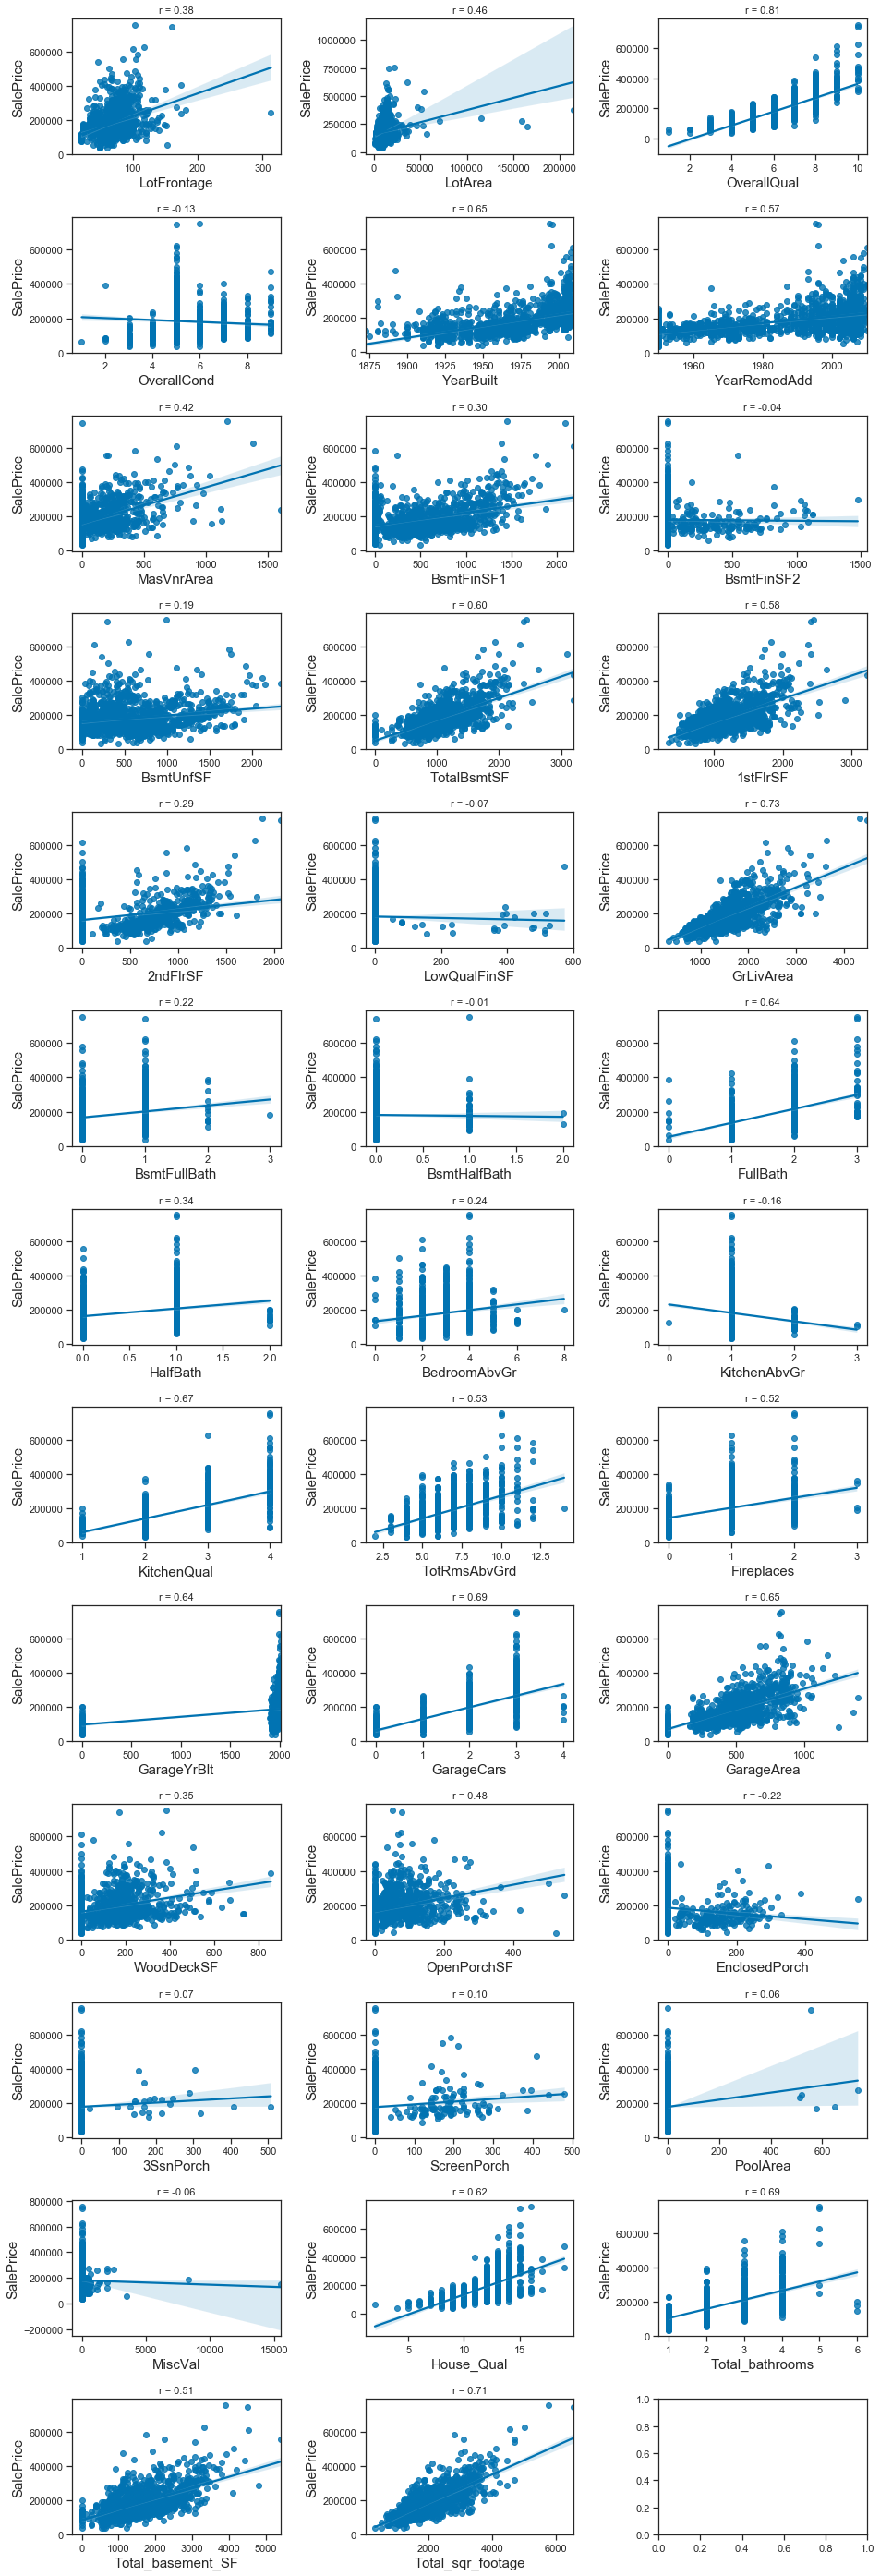

In [24]:
import math
correlation_results_list = []
ncols = 3
nrows = math.ceil(len(numeric_columns)/ncols)
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numeric_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice'], ax = ax)
    stp = spearmanr(X_train[col], X_train['SalePrice'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [25]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df.sort_values(by = 'correlation', ascending = False, inplace = True)
correlation_df.head()

,column_name,correlation
2,OverallQual,0.813513
14,GrLivArea,0.732349
37,Total_sqr_footage,0.707817
35,Total_bathrooms,0.693172
25,GarageCars,0.691027


In [26]:
columns_with_high_corr = correlation_df.loc[correlation_df['correlation']>=0.6, 'column_name'].to_list()
columns_with_high_corr

['OverallQual',
 'GrLivArea',
 'Total_sqr_footage',
 'Total_bathrooms',
 'GarageCars',
 'KitchenQual',
 'YearBuilt',
 'GarageArea',
 'FullBath',
 'GarageYrBlt',
 'House_Qual',
 'TotalBsmtSF']

Dropping numeric columns having low correlation

In [27]:
columns_with_low_corr = correlation_df[correlation_df['correlation']<0.6]['column_name'].to_list()

### Dropping columns having low correlation with SalePrice

In [28]:
data.drop(columns = columns_with_low_corr, inplace = True)
X_train.drop(columns = columns_with_low_corr, inplace = True)

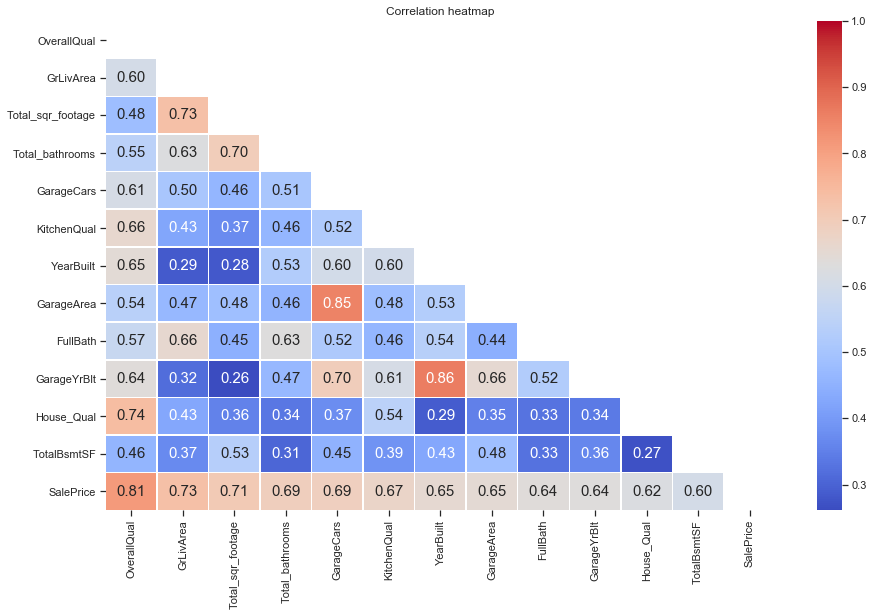

In [29]:
generate_heatmap(X_train[columns_with_high_corr+['SalePrice']])

Dropping columns to avoid multicolinearity
- OverallQual with __House_Qual__ and __KitchenQual__
- __YearBuilt__ with __GarageYrBlt__
- GrLivArea with __Total_sqr_footage__ and __FullBath__ 
- GarageYrBlt with __GarageArea__
- Total_bathrooms with __Total_sqr_footage__
- GarageCars with __GarageArea and GarageYrBlt__

### Dropping columns to avoid multicolinearity

In [30]:
data.drop(columns = ['House_Qual', 'KitchenQual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'FullBath', 'YearBuilt'],
          inplace = True)

X_train.drop(columns = ['House_Qual', 'KitchenQual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'FullBath', 'YearBuilt'],
          inplace = True)

In [31]:
data.shape

(2916, 60)

In [32]:
X_train.shape

(1457, 61)

In [33]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns
category_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'Has_Garage', 'Has_2ndFlr',
       'Has_Pool', 'Has_basement', 'Has_fireplace', 'Has_wooddeck',
       'Has_Open_Porch', 'Has_EnclosedPorch', 'Has_3SsnPorch',
       'Has_ScreenPorch'],
      dtype='object')

### Nominal Categorical and continuous (target) variable

In [34]:
global categ_columns_with_high_association, categ_columns_with_low_association
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice', df = X_train):
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
#     print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = df).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
#     print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
#         print("F-statistic is more than F-critical")
#         print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
#         print("F-statistic is less than F-critical")
#         print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
#     print('-'*30)

In [35]:
for col in category_cols:
    perform_anova_and_its_results(col)

In [36]:
categ_columns_with_low_association

['Street', 'Utilities', 'LandSlope', 'MoSold', 'YrSold', 'Has_3SsnPorch']

#### Dropping columns

In [37]:
data.drop(columns = categ_columns_with_low_association, inplace = True)
X_train.drop(columns = categ_columns_with_low_association, inplace = True)

#### Association between 2 nominal binary variables
Can be used to avoid multicolinearity

In [38]:
def phi_coefficient(a,b):
    temp = pd.crosstab(a,b)
    nr = (temp.iloc[1,1] * temp.iloc[0,0]) - (temp.iloc[0,1]*temp.iloc[1,0])
    dr = np.sqrt(np.product(temp.apply(sum, axis = 'index')) * np.prod(temp.apply(sum, axis = 'columns')))
    return(nr/dr)

In [39]:
cat_binary_cols = []
for col in X_train.select_dtypes(['int32', 'object']).columns:
    if (X_train[col].nunique()==2):
        cat_binary_cols.append(col)
        
cat_binary_cols

['CentralAir',
 'Has_Garage',
 'Has_2ndFlr',
 'Has_Pool',
 'Has_basement',
 'Has_fireplace',
 'Has_wooddeck',
 'Has_Open_Porch',
 'Has_EnclosedPorch',
 'Has_ScreenPorch']

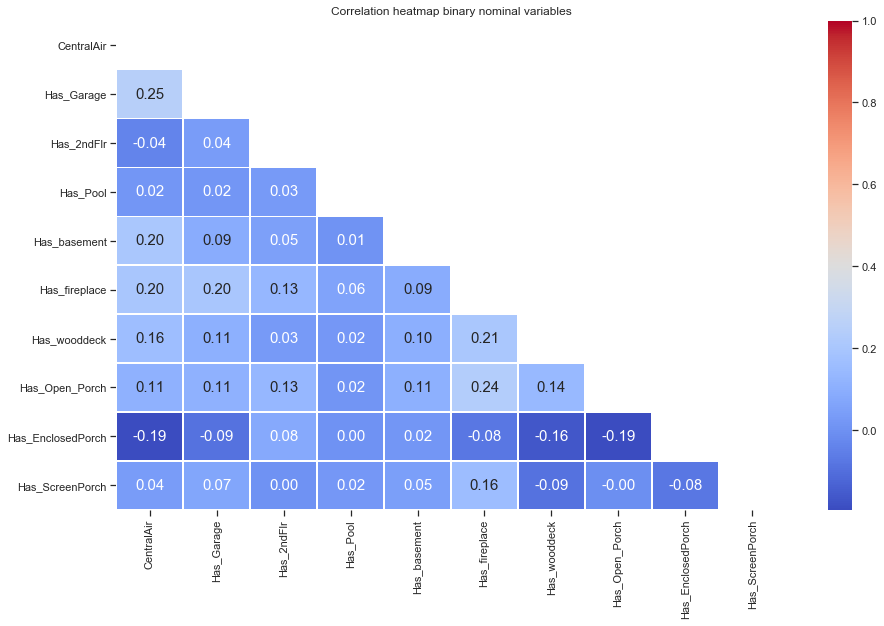

In [40]:
temp = pd.DataFrame(columns=cat_binary_cols, index=cat_binary_cols).fillna(0)
for row in cat_binary_cols:
    a = row
    for col in cat_binary_cols:
        b = col
        temp.loc[a,b] = phi_coefficient(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
          
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(temp, dtype=np.bool))
plt.figure(figsize = (15,9));
# Draw the heatmap with the mask 
sns.heatmap(temp, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
plt.title("Correlation heatmap binary nominal variables");

There is no association or correlation between the nominal and binary variables.

In [41]:
del(cat_binary_cols)

#### EDA - Category and Category analysis



In [42]:
def cramers_v(a,b):
    crosstab = pd.crosstab(a,b)
    chi2 = chi2_contingency(crosstab)[0]  # chi-squared value
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))


from collections import Counter
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return(1)
    else:
        return((s_x - s_xy)/s_x)

In [43]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns.to_list()
category_cols[:10]

['MSSubClass',
 'MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType']

In [44]:
len(category_cols)

49

In [45]:
temp = pd.DataFrame(columns=category_cols, index=category_cols).fillna(0)
cat_col_correlation = []
for row in category_cols:
    a = row
    for col in category_cols:
        b = col
        temp.loc[a,b] = theils_u(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
        cat_col_correlation.append((a,b,temp.loc[a,b]))
          
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(temp, dtype=np.bool))
# plt.figure(figsize = (24,15));
# # Draw the heatmap with the mask 
# sns.heatmap(temp, cmap='coolwarm', mask = mask, linewidths=.005, cbar=False);
# plt.title("Correlation heatmap categorical variables");

In [46]:
cat_cols_corr_df = pd.DataFrame(cat_col_correlation, columns = ['col1', 'col2', 'correlation'])
cat_cols_corr_df.head()

,col1,col2,correlation
0,MSSubClass,MSSubClass,1.000000
1,MSSubClass,MSZoning,0.109543
2,MSSubClass,Alley,0.037093
3,MSSubClass,LotShape,0.030206
4,MSSubClass,LandContour,0.020963


In [47]:
cat_cols_corr_df.shape

(2401, 3)

In [48]:
high_corr_cat=cat_cols_corr_df[(cat_cols_corr_df['correlation']>=0.6) & (cat_cols_corr_df['col1']!=cat_cols_corr_df['col2'])]
high_corr_cat.head()

,col1,col2,correlation
55,MSZoning,Neighborhood,0.672667
441,BldgType,MSSubClass,0.905822
490,HouseStyle,MSSubClass,0.900760
651,Exterior1st,Exterior2nd,0.824017
699,Exterior2nd,Exterior1st,0.797999


In [49]:
high_corr_cat

,col1,col2,correlation
55,MSZoning,Neighborhood,0.672667
441,BldgType,MSSubClass,0.905822
490,HouseStyle,MSSubClass,0.900760
651,Exterior1st,Exterior2nd,0.824017
699,Exterior2nd,Exterior1st,0.797999
1601,GarageQual,GarageCond,0.654260
1647,GarageCond,GarageType,0.613072
1649,GarageCond,GarageQual,0.712726
1757,PoolQC,Has_Pool,0.855235
1990,Has_Garage,GarageType,1.000000


Has multicolinearity

In [50]:
data.drop(columns = ['Has_fireplace', 'Has_basement', 'Has_Pool', 'Has_2ndFlr', 'Has_Garage', 'GarageCond', 
                     'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)
X_train.drop(columns = ['Has_fireplace', 'Has_basement', 'Has_Pool', 'Has_2ndFlr', 'Has_Garage', 'GarageCond', 
                     'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)

In [51]:
data.shape

(2916, 45)

In [52]:
X_train.head()

,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,Functional,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Total_bathrooms,Has_wooddeck,Has_Open_Porch,Has_EnclosedPorch,Has_ScreenPorch,SalePrice
0,None,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856.0,GasA,Ex,Y,SBrkr,1710,Typ,None,Attchd,RFn,2.0,TA,Y,None,None,None,WD,Normal,4.0,0,1,0,0,208500
1,None,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262.0,GasA,Ex,Y,SBrkr,1262,Typ,TA,Attchd,RFn,2.0,TA,Y,None,None,None,WD,Normal,3.0,1,0,0,0,181500
2,None,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920.0,GasA,Ex,Y,SBrkr,1786,Typ,TA,Attchd,RFn,2.0,TA,Y,None,None,None,WD,Normal,4.0,0,1,0,0,223500
3,None,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756.0,GasA,Gd,Y,SBrkr,1717,Typ,Gd,Detchd,Unf,3.0,TA,Y,None,None,None,WD,Abnorml,2.0,0,1,1,0,140000
4,None,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145.0,GasA,Ex,Y,SBrkr,2198,Typ,TA,Attchd,RFn,3.0,TA,Y,None,None,None,WD,Normal,4.0,1,1,0,0,250000


In [53]:
t = X_train.select_dtypes(['int64', 'float64']).columns.tolist()
t.remove('SalePrice')
t

['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'Total_bathrooms']

Checking whether the columns are normally distributed

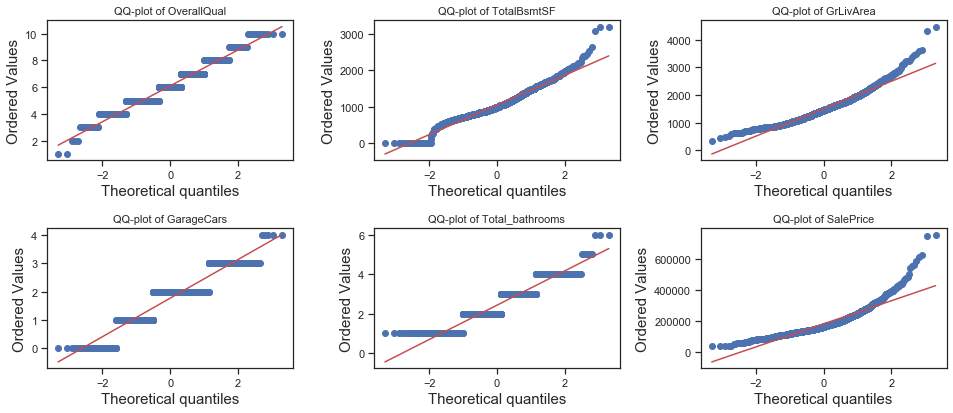

In [54]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in X_train.select_dtypes(['int64', 'float64']).columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

#### Applying log(1+x) transform on SalePrice

In [55]:
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])

Converting other numerical columns to normal

In [56]:
for col in t:
    X_train[col] = boxcox1p(X_train[col], boxcox_normmax(X_train[col]+1))
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col]+1))

Checking the normality of the columns again

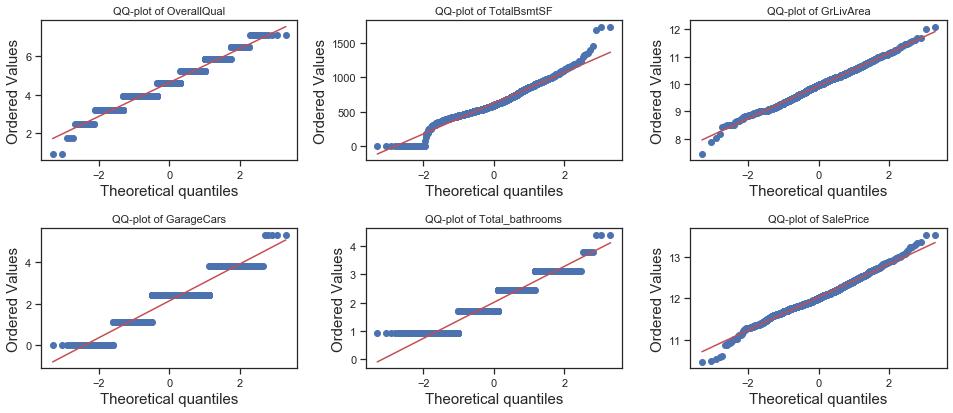

In [57]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in X_train.select_dtypes(['int64', 'float64']).columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

#### Nominal columns

In [58]:
nominal_cols = X_train.select_dtypes('object').columns.to_list()
nominal_cols

['Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

## Modelling

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV, SelectKBest

In [60]:
data.shape

(2916, 45)

In [61]:
X_train.shape

(1457, 46)

In [62]:
train = data.iloc[:len(X_train),:].copy()
train['SalePrice'] = X_train['SalePrice'].copy()
test = data.iloc[len(X_train):,:].copy()

In [63]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (1457, 46)
Test shape:  (1459, 45)


In [64]:
X = train.loc[:,train.columns!='SalePrice']
y = train['SalePrice'].copy()
X.shape

(1457, 45)

In [65]:
X.head()

,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,Functional,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Total_bathrooms,Has_wooddeck,Has_Open_Porch,Has_EnclosedPorch,Has_ScreenPorch
0,None,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,5.391961,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,418.285563,GasA,Ex,Y,SBrkr,8.339937,Typ,None,Attchd,RFn,2.241648,TA,Y,None,None,None,WD,Normal,2.574272,0,1,0,0
1,None,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,4.715004,Gable,CompShg,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,587.580029,GasA,Ex,Y,SBrkr,7.962252,Typ,TA,Attchd,RFn,2.241648,TA,Y,None,None,None,WD,Normal,2.069778,1,0,0,0
2,None,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,5.391961,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,445.546037,GasA,Ex,Y,SBrkr,8.394286,Typ,TA,Attchd,RFn,2.241648,TA,Y,None,None,None,WD,Normal,2.574272,0,1,0,0
3,None,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,5.391961,Gable,CompShg,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,375.167203,GasA,Gd,Y,SBrkr,8.345040,Typ,Gd,Detchd,Unf,3.484370,TA,Y,None,None,None,WD,Abnorml,1.503543,0,1,1,0
4,None,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,6.052677,Gable,CompShg,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,539.609942,GasA,Ex,Y,SBrkr,8.654708,Typ,TA,Attchd,RFn,3.484370,TA,Y,None,None,None,WD,Normal,2.574272,1,1,0,0


#### one hot encoder

In [66]:
ohe_dict_cols = {}
for col in X.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(X[col].unique()).to_list()
    
# For one-hot encoder
t_k = []  # nominal column names
t_v = []  # values of nominal columns
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

#### Ordinal Encoder

In [67]:
ord_encod_dict = {}
for col in X.select_dtypes(include='category').columns:
    ord_encod_dict[col] = pd.Series(data[col].unique().sort_values()).to_list()

# For ordinal encoder
ordinal_cols = []
ordinal_vals = []
for k,v in ord_encod_dict.items():
    ordinal_cols.append(k)
    ordinal_vals.append(v)

In [68]:
number_cols = X.select_dtypes('number').columns.tolist()

In [69]:
number_cols=[ele for ele in number_cols if ele not in ['Has_wooddeck', 'Has_Open_Porch','Has_EnclosedPorch', 'Has_ScreenPorch']]
number_cols

['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'Total_bathrooms']

In [70]:
colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

[StratifiedKFold v.s KFold v.s StratifiedShuffleSplit](https://www.google.com/search?q=difference+between+kfold+and+stratified+kfold&rlz=1C1AVFC_enIN900IN900&oq=differe&aqs=chrome.1.69i57j35i39l2j0l5.2243j0j7&sourceid=chrome&ie=UTF-8)

In [71]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

#### [Learning to use Pipelines](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)

### 1a. Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

pipeline = Pipeline(steps = [("colT", colT), ("regl", lin_reg)])
param_grid = {"regl__fit_intercept": [True, False]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lin_reg = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))

training time: 3.245s
testing time: 0.031s


In [73]:
print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", -grid.best_score_)

Best gird parameters :  {'regl__fit_intercept': True}
RMSE:  0.17587043524235527


### 1b. Linear Regression with SelectKBest

In [74]:
kbest = SelectKBest(f_regression)

pipeline = Pipeline(steps = [("colT", colT), ('kbest', kbest), ("regl", lin_reg)])
param_grid = {"kbest__k": [70,75,80,85],
              "regl__fit_intercept": [True, False]}



grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lin_reg = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))

training time: 9.261s
testing time: 0.031s


In [75]:
print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", -grid.best_score_)

Best gird parameters :  {'regl__fit_intercept': True, 'kbest__k': 80}
RMSE:  0.1836618890363381


In [76]:
reg.named_steps['kbest']

SelectKBest(k=80, score_func=<function f_regression at 0x00000246F25D95E8>)

[Why GridSearchCV not same as cross-val-score?](https://stackoverflow.com/questions/50879932/gridsearchcv-best-score-not-same-as-cross-val-scoregridsearchcv-best-estimator)

when an integer number is passed to GridSearchCV(..., cv=int_number) parameter, then the StratifiedKFold will be used for cross-validation splitting. So the data set will be randomly splitted by StratifiedKFold. This might affect the accuracy and therefore the best score.

In [77]:
model_lin_reg = reg

In [78]:
accuracies = -cross_val_score(model_lin_reg, X, y, scoring="neg_root_mean_squared_error", cv = kf, n_jobs = -1)
accuracies

array([0.17570665, 0.19278165, 0.17658495, 0.21144347, 0.19073541,
       0.17169251, 0.18118527, 0.18795312, 0.19082713, 0.19501764,
       0.17895753, 0.17870563])

In [79]:
accuracies.mean()

0.18596591367979518

In [80]:
accuracies.var()

0.00011245757919722096

In [81]:
accuracies.std()

0.010604601793430103

In [82]:
rfecv = RFECV(estimator=lin_reg, step=1, cv=12, scoring='neg_root_mean_squared_error')
rfecv = rfecv.fit(colT.fit_transform(X), y)
rfecv

RFECV(cv=12,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_root_mean_squared_error', step=1, verbose=0)

In [83]:
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 142


## 1c. Linear Regression with RFE

In [84]:
lin_reg = LinearRegression()

rfe = RFE(lin_reg)

pipeline = Pipeline(steps = [("colT", colT), ('rfe', rfe),("regl", lin_reg)])
param_grid = {"regl__fit_intercept": [True, False]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lin_reg_rfe = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))

training time: 89.777s
testing time: 0.031s


In [85]:
print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", -grid.best_score_)

Best gird parameters :  {'regl__fit_intercept': True}
RMSE:  0.19757350171514526


### 2a. DecisionTreeRegressor

[Decision Tree Parameters explanaton](https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d)

In [86]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state=0)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

pipeline = Pipeline(steps = [('colt', colT), ('kbest', kbest), ("dt", dtreg)])
param_grid = {"kbest__k":[75,80,85,90,95,100],
              "dt__splitter": ['best', 'random'],
             "dt__max_depth": [2,3,4,5, 6,7,8,9,None],
             "dt__max_features":['auto', 'sqrt']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_dt = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE DT: ", -grid.best_score_)

training time: 164.065s
testing time: 0.031s
Best gird parameters :  {'dt__max_depth': 7, 'dt__max_features': 'auto', 'dt__splitter': 'best', 'kbest__k': 100}
RMSE DT:  0.18496907488728942


### 3. Random Forest Regressor

In [87]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


pipeline = Pipeline(steps = [('colt', colT), ('kbest', kbest), ("rf", rfreg)])
param_grid = {"kbest__k":[75,80,85,90,95,100,105],
              "rf__n_estimators": [70,100,110,120], # number of trees in the forest.
             "rf__max_depth": [5,7,8 ,9, 10],
             "rf__max_features":['auto', 'sqrt']}


grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_rf = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE DT: ", -grid.best_score_)

training time: 145.936s
testing time: 0.062s
Best gird parameters :  {'rf__n_estimators': 100, 'rf__max_features': 'auto', 'rf__max_depth': 9, 'kbest__k': 90}
RMSE DT:  0.1417035254479132


### 4. XGBoost

[HyperParameters for XGboost](https://www.datacamp.com/community/tutorials/xgboost-in-python#what)

In [88]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3)

In [89]:
colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ("xg", xg_reg)])
param_grid = {"SKB__k":[55, 65, 75, 80,85,90,95,100,105], 
              "xg__alpha": [5, 8, 10, 12, 15],
              "xg__n_estimators": [10,20,30,40],
              "xg__learning_rate": [0.1,0.3,0.5,0.7],
             "xg__max_depth": [2,3,4,5],
             "xg__max_features":['auto', 'sqrt']}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_XG_1 = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE XG: ", -grid.best_score_)

training time: 11.149s
testing time: 0.047s
Best gird parameters :  {'xg__n_estimators': 40, 'xg__max_features': 'sqrt', 'xg__max_depth': 2, 'xg__learning_rate': 0.3, 'xg__alpha': 10, 'SKB__k': 100}
RMSE XG:  0.13654309575519014


### 5. Ridge regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [90]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ('rb', rb_scaler), ("ridge", ridge_reg)])
param_grid = {"SKB__k":[65,70,75,80,85,90], 
              "ridge__alpha": [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10,
                               15, 18, 20, 30, 50, 75, 100],
             "ridge__fit_intercept": [True, False],
             "ridge__solver": ['auto', 'svd']}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_ridge = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Ridge: ", -grid.best_score_)

training time: 7.752s
testing time: 0.031s
Best gird parameters :  {'ridge__solver': 'auto', 'ridge__fit_intercept': True, 'ridge__alpha': 0.0003, 'SKB__k': 90}
RMSE Ridge:  0.18236032153591414


### 6. Lasso Regression

In [91]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ('rb', rb_scaler), ("lasso", lasso_reg)])
param_grid = {"SKB__k":[65,70,75,80,85,90],
              "lasso__alpha": [0.0005,0.05,0.25,0.5,1,1.5,2],
             "lasso__fit_intercept": [True, False]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", -grid.best_score_)

training time: 13.794s
testing time: 0.031s
Best gird parameters :  {'lasso__fit_intercept': False, 'lasso__alpha': 0.0005, 'SKB__k': 85}
RMSE Lasso:  0.18375930372175664


### 7. Elastic net regression

In [92]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet()

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ('rb', rb_scaler), ("elastic", elastic_reg)])
param_grid = {"SKB__k":[65,70,75,80,85,90,95,100],
              "elastic__alpha": [0.0005,0.00025,0.05,0.25,0.5,1,1.5,2],
             "elastic__fit_intercept": [True, False],
             "elastic__l1_ratio":[.025,0.05, 0.07,0.08, 0.095]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_elastic = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", -grid.best_score_)

training time: 16.576s
testing time: 0.031s
Best gird parameters :  {'elastic__l1_ratio': 0.05, 'elastic__fit_intercept': False, 'elastic__alpha': 0.00025, 'SKB__k': 65}
RMSE Lasso:  0.191788507714699


## 8. SVR

In [93]:
from sklearn.svm import SVR
svr = SVR()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("svrpara", svr)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31, 32],
              "svrpara__kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
             "svrpara__degree": [2,3,4],
             "svrpara__gamma": ['scale', 'auto'],
             "svrpara__C":[0.5,0.8,1],
             "svrpara__epsilon":[0.08,0.1,0.15,0.2]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_svr = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE SVR: ", -grid.best_score_)

training time: 21.179s
testing time: 0.141s
Best gird parameters :  {'svrpara__kernel': 'rbf', 'svrpara__gamma': 'auto', 'svrpara__epsilon': 0.08, 'svrpara__degree': 4, 'svrpara__C': 0.8, 'SKB__k': 30}
RMSE SVR:  0.20686146797850596


### Submission

In [94]:
test = pd.read_csv('test.csv')

In [95]:
sub_pred = np.exp(prediction_XG_1)

In [96]:
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = sub_pred
df_output.head()

,Id,SalePrice
0,1461,121513.523438
1,1462,140632.546875
2,1463,181398.546875
3,1464,171636.796875
4,1465,209851.843750


In [97]:
df_output.to_csv('submission_5.csv', index = False)

In [104]:
progress = pd.DataFrame()
progress['date'] = pd.to_datetime(['2020-05-13', '2020-05-25', '2020-05-31'])
progress['rmse'] = [0.1501, 0.1541, 0.1365]
progress

,date,rmse
0,2020-05-13,0.1501
1,2020-05-25,0.1541
2,2020-05-31,0.1365


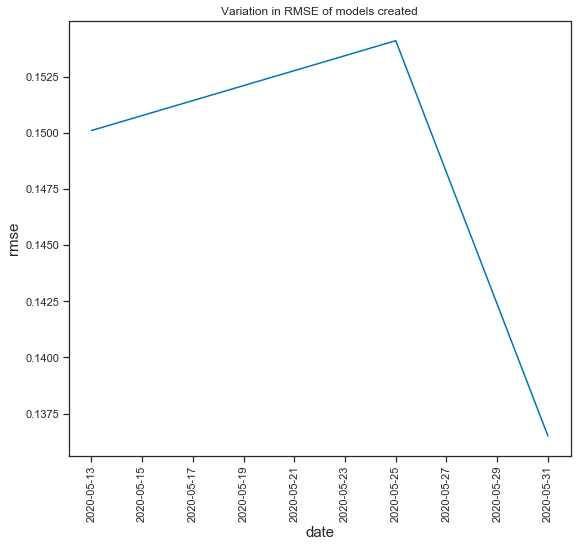

In [106]:
sns.lineplot(data = progress, x = 'date', y = 'rmse');
plt.title('Variation in RMSE of models created');
plt.xticks(rotation=90);